In [1]:
import os
n_cores = 4
os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count={}'.format(n_cores)

from jax import config
config.update("jax_enable_x64", True)

import jax
import jax.numpy as jnp
import numpy as np
import pickle
from jax import jit, vmap, grad, jacrev
from jax.lax import cond, scan
import jax.random as random
key = random.PRNGKey(2022)
import jax.example_libraries.optimizers as optimizers
from jax.flatten_util import ravel_pytree
from jax.sharding import PositionalSharding
from functools import partial

import matplotlib.pyplot as plt
import pandas as pd

from utils import train, coords_2_strain_nn
from utils import train_colloc_parallel as train_colloc, init_params_nn, ff_nn, divergence, bd_forces, a1, a2, lr
from utils_hyperelasticity import NODE, init_layers, NODE_model_aniso, init_params_aniso, GOH_model, eval_Cauchy, eval_Cauchy_vmap, eval_P, eval_P_vmap
from utils_hyperelasticity import ThreeDElasticity
from fem import plotmesh, fe_solver_2D, vahid_anisohyper_inv, apply_bc_biax

from jax_fem.core import FEM
from jax_fem.solver import solver
from jax_fem.utils import save_sol
from jax_fem.generate_mesh import box_mesh, get_meshio_cell_type, Mesh, rectangle_mesh

from PIL import Image, ImageFilter
from jaxinterp2d import interp2d

E_fun = vmap(lambda F: 0.5*(F.T@F - jnp.eye(2)))

       __       ___      ___   ___                _______  _______ .___  ___. 
      |  |     /   \     \  \ /  /               |   ____||   ____||   \/   | 
      |  |    /  ^  \     \  V  /      ______    |  |__   |  |__   |  \  /  | 
.--.  |  |   /  /_\  \     >   <      |______|   |   __|  |   __|  |  |\/|  | 
|  `--'  |  /  _____  \   /  .  \                |  |     |  |____ |  |  |  | 
 \______/  /__/     \__\ /__/ \__\               |__|     |_______||__|  |__| 
                                                                              



In [2]:
# Neo Hookean Material model
class neoHook():
    def __init__(self, C10):
        self.C10 = jnp.exp(C10)
        self.theta = 0.0

    def Psi1(self, I1, I2, Iv, Iw):
        C10 = self.C10
        return C10

    def Psiv(self, I1, I2, Iv, Iw):
        return 0.0
    
    def Psi2(self, I1, I2, Iv, Iw):
        return 0.0
    
    def Psiw(self, I1, I2, Iv, Iw):
        return 0.0

In [3]:
with open('data/manu/stiff2_hetero.npy', 'rb') as f:
    x,y,F_hist = pickle.load(f)
elem_X = np.stack([x.T.flatten(),y.T.flatten()]).T

force_disp = pd.read_csv('data/manu/Stiff2_Hetero_Final_42x41/force_disp.csv')
time = force_disp.Time[1:].to_numpy().astype(np.float64)
force = force_disp.Force[1:].to_numpy().astype(np.float64)

n_steps = len(F_hist)
new_time_range = np.linspace(0,time.max(),n_steps)
new_force_range = np.interp(new_time_range, time, force)
t_hist = new_time_range/new_time_range.max()
force = new_force_range

# we don't need to use all of that data
skip = 30
F_hist = F_hist[10::30]
time = time[10::30]
force = force[10::30]

In [4]:
ele_type = 'QUAD4'
cell_type = get_meshio_cell_type(ele_type)

Nx, Ny = x.shape[1], x.shape[0]
Lx, Ly = 1.0, 1.0
meshio_mesh = rectangle_mesh(Nx=Nx, Ny=Ny, domain_x=Lx, domain_y=Ly)
mesh = Mesh(meshio_mesh.points, meshio_mesh.cells_dict[cell_type])

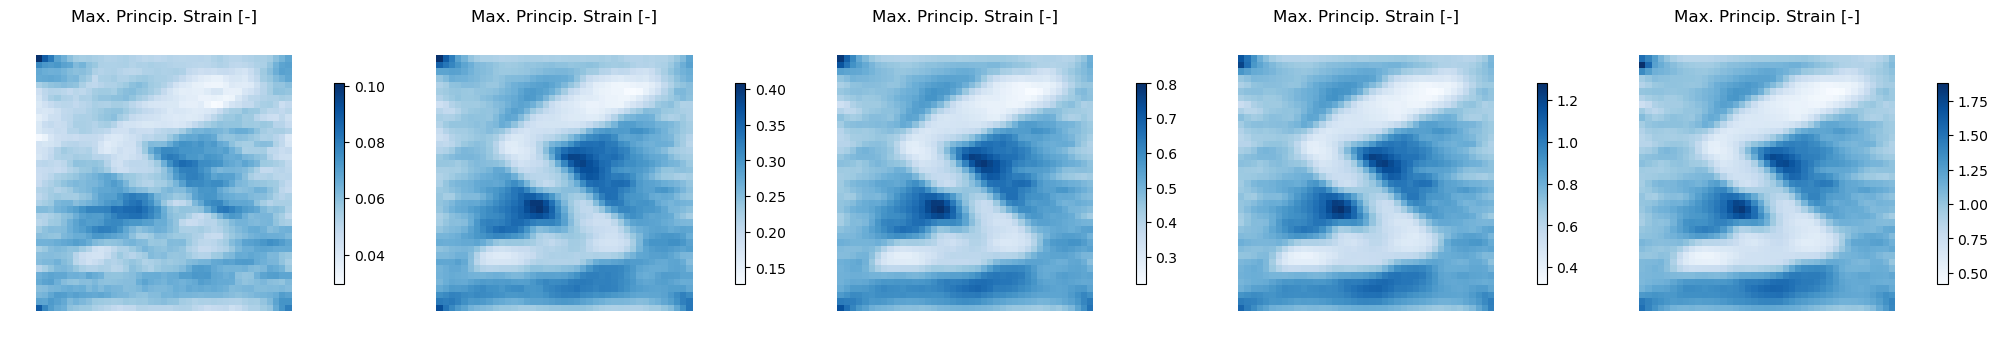

In [5]:
n_panels = 5
fig, axes = plt.subplots(1,n_panels,figsize=(5*n_panels,4))
strains = []
t_hist = np.arange(len(F_hist))
for i in range(len(F_hist)):
    F = F_hist[i]
    t = t_hist[i]
    E = E_fun(F)
    evals, efuns = jnp.linalg.eigh(E)
    E_11, E_22 = evals.T

    mps = np.maximum(E_11, E_22)
    strains.append(np.array([t*np.ones(len(F)), F[:,0,0], F[:,0,1], F[:,1,0], F[:,1,1]]))

    if i < n_panels:
        ax = axes[i]
        plotmesh(mesh.cells, mesh.points, mps, title='Max. Princip. Strain [-]', ax=ax, ec='None'); 

strains = np.hstack(strains)

### Coords_2_strain NN

In [6]:
# instead of using a 2D spline, use a NN to get the strain field for a given (x,y)
def loss_coords_2_strain(params, X, key):
    inp, out_gt = X[:,:3], X[:,3:] #inp: x,y,lmb and out_gt=eps_xx, eps_yy
    t = inp[:,2:3]
    out_pr = coords_2_strain_nn(inp, params)
    out_gt = out_gt/(t+1) #dividing by t+1 just for some regularization
    out_pr = out_pr/(t+1) #dividing by t+1 just for some regularization
    return jnp.mean((out_pr-out_gt)**2)

n_ff = 20 # 10 cosines and 10 sines in the fourier features
n_inp = 2 # x, y
ff_params = np.random.normal(size=n_inp*n_ff).reshape([n_inp,n_ff])*0.5
nn_layers = [2*n_ff+1,20,20,4]
nn_params = init_params_nn(nn_layers, key)
coord_2_strain_params = [ff_params, nn_params]

opt_init, opt_update, get_params = optimizers.adam(5.e-4)
opt_state = opt_init(coord_2_strain_params)

X = np.vstack([elem_X]*len(F_hist))
inp = np.hstack([X, strains.T])
coord_2_strain_params, train_loss, _ = train(loss_coords_2_strain, inp, get_params, opt_update, opt_state, key, nIter = 50000, print_freq=1000, batch_size=10000)

it 1000, train loss = 4.716268e-04
it 2000, train loss = 2.969484e-04
it 3000, train loss = 2.408752e-04
it 4000, train loss = 2.055408e-04
it 5000, train loss = 1.644206e-04
it 6000, train loss = 1.376039e-04
it 7000, train loss = 1.137704e-04
it 8000, train loss = 9.272416e-05
it 9000, train loss = 7.922551e-05
it 10000, train loss = 6.930382e-05
it 11000, train loss = 6.042000e-05
it 12000, train loss = 5.532166e-05
it 13000, train loss = 5.012465e-05
it 14000, train loss = 4.639460e-05
it 15000, train loss = 4.372808e-05
it 16000, train loss = 4.160850e-05
it 17000, train loss = 3.966561e-05
it 18000, train loss = 3.774131e-05
it 19000, train loss = 3.680439e-05
it 20000, train loss = 3.537937e-05
it 21000, train loss = 3.411931e-05
it 22000, train loss = 3.323792e-05
it 23000, train loss = 3.288584e-05
it 24000, train loss = 3.240023e-05
it 25000, train loss = 3.145568e-05
it 26000, train loss = 3.193419e-05
it 27000, train loss = 3.109658e-05
it 28000, train loss = 3.056648e-05
i

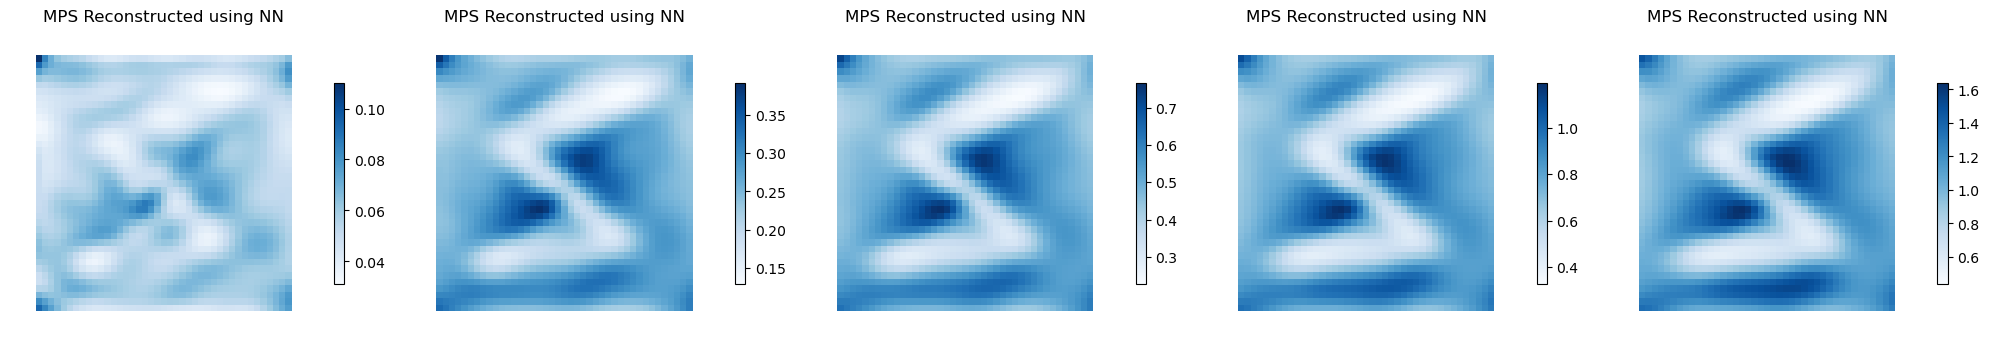

In [7]:
fig, axes = plt.subplots(1,5,figsize=(25,4))
for t in t_hist:
    aux = np.hstack([elem_X, t*np.ones_like(elem_X[:,:1])])
    F_xx, F_xy, F_yx, F_yy = coords_2_strain_nn(aux, coord_2_strain_params).T
    F = np.stack([F_xx, F_xy, F_yx, F_yy]).T.reshape([-1,2,2])
    
    E = E_fun(F)
    evals, efuns = jnp.linalg.eigh(E)
    E_11, E_22 = evals.T
    mps = np.maximum(E_11, E_22)

    if t < 5:
        plotmesh(mesh.cells, mesh.points, mps, title='MPS Reconstructed using NN', ax=axes[t], ec='None'); 

In [8]:
# identify the boundaries
rgt_bd_elems = []
top_bd_elems = []
lft_bd_elems = []
bot_bd_elems = []
for i, e in enumerate(mesh.cells):
    if any([mesh.points[e[i],0]>0.99 for i in range(4)]):
        rgt_bd_elems.append(i)
    if any([mesh.points[e[i],1]>0.99 for i in range(4)]):
        top_bd_elems.append(i)
    if any([mesh.points[e[i],0]<0.01 for i in range(4)]):
        lft_bd_elems.append(i)
    if any([mesh.points[e[i],1]<0.01 for i in range(4)]):
        bot_bd_elems.append(i)

Force_y = force
Force_x = force*0.0

# get the center points of the elements
rgt_bd_X = elem_X[rgt_bd_elems]
top_bd_X = elem_X[top_bd_elems]
lft_bd_X = elem_X[lft_bd_elems]
bot_bd_X = elem_X[bot_bd_elems]
bd_X = rgt_bd_X, top_bd_X, lft_bd_X, bot_bd_X

In [9]:
Force_x = jnp.array(Force_x)
Force_y = jnp.array(Force_y)

In [65]:
# Assume stress is constant (only axial) but strain is not
P_xx_mean = Force_x/len(rgt_bd_elems)
P_yy_mean = Force_y/len(top_bd_elems)

@jit
def loss_stress(Lambda_params, inp, key):
    X, Y, t = inp
    model_params = ff_nn(jnp.array([X,Y])[None,:], Lambda_params)
    F_xx, F_xy, F_yx, F_yy = coords_2_strain_nn(inp[None,:], coord_2_strain_params).flatten()
    
    model = neoHook(model_params)
    P = eval_P(F_xx, F_xy, F_yx, F_yy, model)
    P_xx_pr, P_yy_pr = P[0,0], P[1,1]
    return np.mean((P_xx_mean-P_xx_pr)**2 + (P_yy_mean-P_yy_pr)**2)

loss_stress_vmap = vmap(loss_stress, in_axes=(None, 0, None))
loss_stress_vmap2 = lambda a,b,c: jnp.mean(loss_stress_vmap(a,b,c))

X = []
for t in t_hist:
    X.append(jnp.hstack([elem_X, jnp.ones([len(elem_X),1])*t]))
X = jnp.vstack(X)


n_ff = 10
ff_params = np.random.normal(size=2*n_ff).reshape([2,n_ff])
nn_layers = [2*n_ff,10,10,1]
nn_params = init_params_nn(nn_layers, key)
Lambda_params = [ff_params, nn_params]
opt_init, opt_update, get_params = optimizers.adam(5.e-4) #Original: 1.e-4
opt_state = opt_init(Lambda_params)

Lambda_params, train_loss, _ = train(loss_stress_vmap2, X, get_params, opt_update, opt_state, key, nIter = 15000, print_freq=1000)

it 1000, train loss = 4.244870e-02
it 2000, train loss = 3.261756e-02
it 3000, train loss = 3.108023e-02
it 4000, train loss = 3.021551e-02
it 5000, train loss = 2.982284e-02
it 6000, train loss = 2.961903e-02
it 7000, train loss = 2.948098e-02
it 8000, train loss = 2.937050e-02
it 9000, train loss = 2.927508e-02
it 10000, train loss = 2.919583e-02
it 11000, train loss = 2.913514e-02
it 12000, train loss = 2.907521e-02
it 13000, train loss = 2.901203e-02
it 14000, train loss = 2.896387e-02
it 15000, train loss = 2.893280e-02


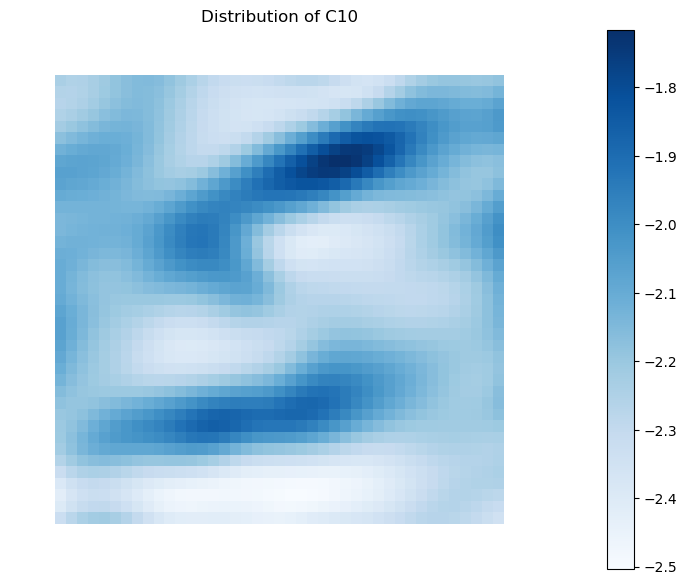

In [77]:
C10 = ff_nn(X[:len(F),:2], Lambda_params).flatten()
plotmesh(mesh.cells, mesh.points, C10, title='Distribution of C10', ec='None'); 

In [78]:
with open('params/GOH_pre_stiff2_pre.npy', 'wb') as f:
    pickle.dump([coord_2_strain_params, Lambda_params, mesh, elem_X, Force_x, Force_y, strains,
                 bd_X, F_hist, t_hist], f)

## 2. Retrain

In [79]:
with open('params/GOH_pre_stiff2_pre.npy', 'rb') as f:
    coord_2_strain_params, Lambda_params, mesh, elem_X, Force_x, Force_y, strains, \
                 bd_X, F_hist, t_hist = pickle.load(f)

In [80]:
# Train
a1 = 10000

def loss_div(Lambda_params, XYt_colloc):
    Div_x, Div_y = divergence(Lambda_params, XYt_colloc, coord_2_strain_params, neoHook)
    loss_Div = a1*(Div_x**2 + Div_y**2)
    return loss_Div
def loss_force(Lambda_params, XYt_colloc):
    def bd_forces_loss(_, t):
        F_rgt, F_top, F_lft, F_bot = bd_forces(Lambda_params, t, bd_X, coord_2_strain_params, neoHook)
        Fx = Force_x[jnp.array(t, int)]
        Fy = Force_y[jnp.array(t, int)]
        return None, a2*((F_rgt-Fx)**2 + (F_top-Fy)**2 + (F_lft-Fx)**2 + (F_bot-Fy)**2)
    loss_F = jnp.mean(scan(bd_forces_loss, init=None, xs=t_hist)[1])
    return loss_F

@jit
def loss(Lambda_params, XYt_colloc):
    return loss_div(Lambda_params, XYt_colloc) + loss_force(Lambda_params, XYt_colloc)

lr = optimizers.exponential_decay(1e-4, 1000, 0.9)
sharding = PositionalSharding(jax.devices()).reshape(n_cores, 1)
opt_init, opt_update, get_params = optimizers.adam(lr) 
opt_state = opt_init(Lambda_params)

node_X_ext = jnp.hstack([mesh.points, t_hist[-1]*np.ones_like(mesh.points[:,:1])])
metric1 = lambda params, X:  bd_forces(params, t_hist[-1], bd_X, coord_2_strain_params, neoHook)
metric2 = lambda params, X: divergence(params, node_X_ext, coord_2_strain_params, neoHook)

Lambda_params, val_loss, metrics = train_colloc(loss, [mesh.points, t_hist], get_params, opt_update, opt_state, 
                                            key, sharding, None, nIter = 50000, print_freq=1000, metric_fns = [loss_div, loss_force], batch_size=5000)

with open('params/GOH_pre_stiff2_post.npy', 'wb') as f:
    pickle.dump([mesh, elem_X, strains, Force_x, Force_y, C10, Lambda_params, val_loss, metrics, t_hist], f)

it 1000, val loss = 3.948503e+00
it 2000, val loss = 3.372614e+00
it 3000, val loss = 1.602295e+00
it 4000, val loss = 1.811384e+00
it 5000, val loss = 1.807915e+00
it 6000, val loss = 3.427950e+00
it 7000, val loss = 1.936428e+00
it 8000, val loss = 1.451686e+00
it 9000, val loss = 2.273538e+00
it 10000, val loss = 1.945460e+00
it 11000, val loss = 1.538428e+00
it 12000, val loss = 1.395639e+00
it 13000, val loss = 1.540231e+00
it 14000, val loss = 1.404296e+00
it 15000, val loss = 1.324656e+00
it 16000, val loss = 1.617296e+00
it 17000, val loss = 1.279990e+00
it 18000, val loss = 1.740329e+00
it 19000, val loss = 1.292481e+00
it 20000, val loss = 1.340928e+00
it 21000, val loss = 1.651006e+00
it 22000, val loss = 1.086026e+00
it 23000, val loss = 1.376018e+00
it 24000, val loss = 1.629690e+00
it 25000, val loss = 1.498880e+00
it 26000, val loss = 1.074165e+00
it 27000, val loss = 1.232475e+00
it 28000, val loss = 1.420118e+00
it 29000, val loss = 1.331733e+00
it 30000, val loss = 1.

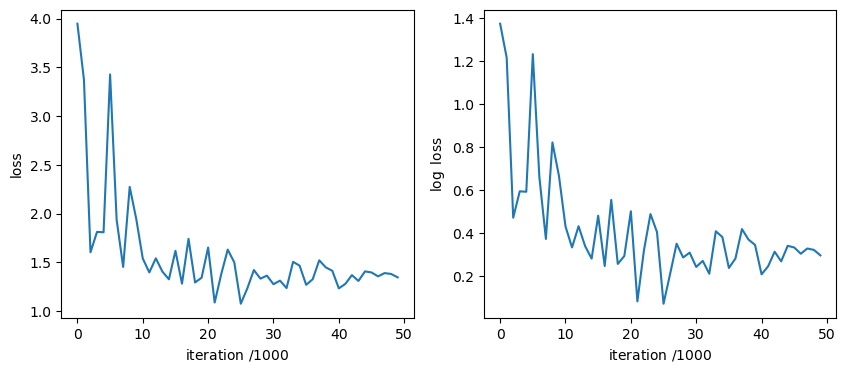

In [81]:
fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(val_loss)
ax[1].plot(np.log(val_loss))

ax[0].set(xlabel='iteration $/1000$', ylabel='loss')
ax[1].set(xlabel='iteration $/1000$', ylabel='$\log$ loss'); 

## 3. Test

In [82]:
with open('params/GOH_pre_stiff2_post.npy', 'rb') as f:
    mesh, elem_X, strains, Force_x, Force_y, node_params, Lambda_params, val_loss, metrics, t_hist = pickle.load(f)
_, unravel = ravel_pytree(node_params)
NODE_w_unravel = lambda params: NODE_model_aniso(unravel(params))

In [83]:
cell_type = get_meshio_cell_type('QUAD4')

Nx, Ny = 50, 50
Lx, Ly = 1.0, 1.0
meshio_mesh = rectangle_mesh(Nx=Nx, Ny=Ny, domain_x=Lx, domain_y=Ly)
mesh2 = Mesh(meshio_mesh.points, meshio_mesh.cells_dict[cell_type])
elem_X2 = mesh2.points[mesh2.cells].mean(axis=1)

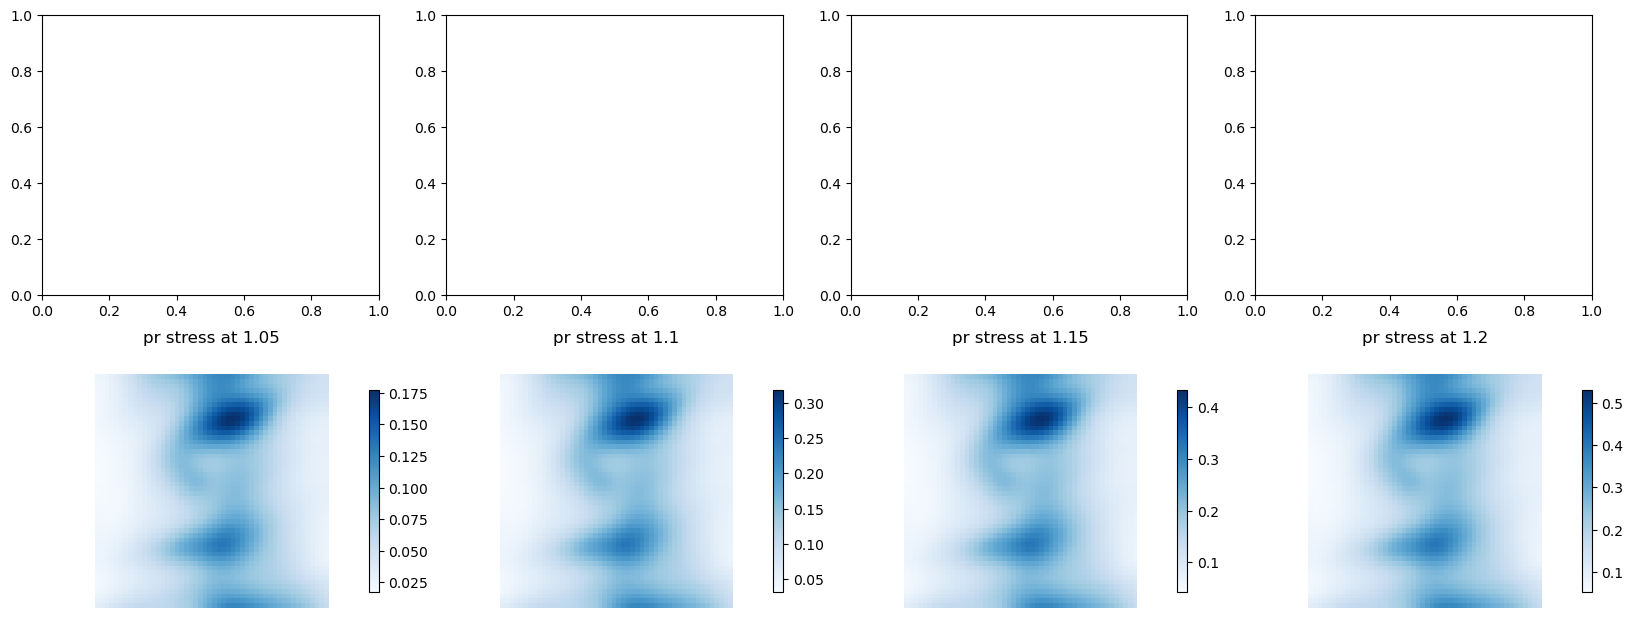

In [84]:
# Stiffness across the domain
fig, axes = plt.subplots(2,4,figsize=(20,8))
lmb_hist = [1.05, 1.1, 1.15, 1.2]

extents = [[0.0, 1.0],
           [0.0, 1.5],
           [0.0, 2.0],
           [0.0, 3.0]]
for lmb, ax, extent in zip(lmb_hist, axes.T, extents):
    ugrad = jnp.array([[lmb-1.0, 0.0], [0.0, lmb-1.0]])

    # params_gt = []
    # for xy in elem_X:
    #     params_gt.append(coords_2_params_gt(xy))
    # params_gt = np.array(params_gt)
    params_pr = ff_nn(elem_X2, Lambda_params)

    # c_elem_gt = []
    c_elem_pr = []
    # for params_gt_i, params_pr_i in zip(params_gt, params_pr):
    for params_pr_i in params_pr:
        # c_elem_gt.append(ThreeDElasticity(GOH_model).ugrad_2_P(ugrad, params_gt_i, 2)[0,0])
        c_elem_pr.append(ThreeDElasticity(neoHook).ugrad_2_P(ugrad, params_pr_i, 2)[0,0])
    
    # plotmesh(mesh.cells, mesh.points, c_elem_gt, title='gt stress at {}'.format(str(lmb)), ax=ax[0]); 
    # extent = [np.min(c_elem_gt), np.max(c_elem_gt)]
    # if extent[0] > np.min(c_elem_pr) and extent[1] < np.max(c_elem_pr):
    #     extend='both'
    # elif extent[0] > np.min(c_elem_pr):
    #     extend='min'
    # elif extent[1] < np.max(c_elem_pr):
    #     extend='max'
    plotmesh(mesh2.cells, mesh2.points, c_elem_pr, title='pr stress at {}'.format(str(lmb)), ax=ax[1], ec='None'); 

In [4]:
P_vmap = vmap(ThreeDElasticity(NODE_w_unravel).ugrad_2_P, in_axes=(0, 0, None))
class HyperElasticity(FEM):
    def get_tensor_map(self):
        return lambda u_grad, params: ThreeDElasticity(NODE_w_unravel).ugrad_2_P(u_grad, params, self.dim)
    
    def set_params(self, params_vec):
        self.internal_vars['laplace'] = [params_vec]

In [5]:
params_vec = []
for x, y in elem_X:
    Lambda_inp = np.array([x,y]).reshape([-1,2])
    phi = ff_nn(Lambda_inp, Lambda_params).flatten()
    params_vec.append(phi)
params_vec = jnp.array(params_vec).reshape([len(params_vec),1,-1])
params_vec = jnp.repeat(params_vec, axis=1, repeats=4)

In [6]:
ele_type = 'QUAD4'
cell_type = get_meshio_cell_type(ele_type)

Nx, Ny = 19, 19
Lx, Ly = 1.0, 1.0
meshio_mesh = rectangle_mesh(Nx=Nx, Ny=Ny, domain_x=Lx, domain_y=Ly)
mesh = Mesh(meshio_mesh.points, meshio_mesh.cells_dict[cell_type])


# Functions to identify the boundary nodes
def bottom(point):
    return jnp.isclose(point[1], 0., atol=1e-5)
def left(point):
    return jnp.isclose(point[0], 0., atol=1e-5)
def top(point):
    return jnp.isclose(point[1], Ly, atol=1e-5)
def right(point):
    return jnp.isclose(point[0], Lx, atol=1e-5)
def bottom_left(point):
    return jnp.logical_and(jnp.logical_and(bottom(point), left(point)), jnp.isclose(point[2], 0., atol=1e-5))


# Functions to assign dirichlet BCs
def zero_dirichlet(point):
    return 0.
def lmbx_max_dirichlet(point, lmbx_max):
    return Lx*lmbx_max - 1.0
def lmby_max_dirichlet(point, lmby_max):
    return Ly*lmby_max - 1.0


lmb_hist = [1.05, 1.10, 1.15, 1.20]
n_elem = Nx*Ny
C10 = jnp.zeros(n_elem)
k1  = jnp.zeros(n_elem)
k2  = jnp.zeros(n_elem)
F_hist = []
node_x_hist = []
P_hist = []
for lmb_max in lmb_hist:
    dirichlet_bc_info = [
        [bottom,            left,           top,                                        right,                                  ],
        [1,                 0,              1,                                          0,                                      ],
        [zero_dirichlet,    zero_dirichlet, lambda p: lmby_max_dirichlet(p, lmb_max),   lambda p: lmbx_max_dirichlet(p, lmb_max)]
    ]
    problem = HyperElasticity(mesh,
                            vec=2,
                            dim=2,
                            ele_type=ele_type,
                            dirichlet_bc_info=dirichlet_bc_info)
    elem_X = problem.get_physical_quad_points().mean(1)

    problem.set_params(params_vec)


    node_x = solver(problem, use_petsc=True)
    u_grad = np.mean(problem.sol_to_grad(node_x), axis=1)
    F = u_grad + np.eye(2)
    P = P_vmap(u_grad, params_vec[:,0,:], 2)
    
    F_hist.append(F)
    node_x_hist.append(node_x)
    P_hist.append(P)
node_x_hist = np.array(node_x_hist)
F_hist = np.array(F_hist)
P_hist = np.array(P_hist)

[01-29 12:02:18][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[01-29 12:02:18][DEBUG] jax_fem: ele_type = QUAD4, quad_points.shape = (num_quads, dim) = (4, 2)
[01-29 12:02:18][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (4, 2, 2)
[01-29 12:02:19][DEBUG] jax_fem: Done pre-computations, took 0.3462047576904297 [s]
[01-29 12:02:19][INFO] jax_fem: Solving a problem with 361 cells, 400x2 = 800 dofs.
[01-29 12:02:19][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[01-29 12:02:19][DEBUG] jax_fem: Start timing
[01-29 12:02:19][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[01-29 12:02:22][DEBUG] jax_fem: Function split_and_compute_cell took 2.7130 seconds
[01-29 12:02:22][DEBUG] jax_fem: Creating sparse matrix with scipy...
[01-29 12:02:22][DEBUG] jax_fem: Linear guess solve...
[01-29 12:02:22][DEBUG] jax_fem: PETSc - Solving with ksp_type = bcgsl, pc = ilu
[01-29 12:02:22][DEBUG] jax_fem: PETSc 

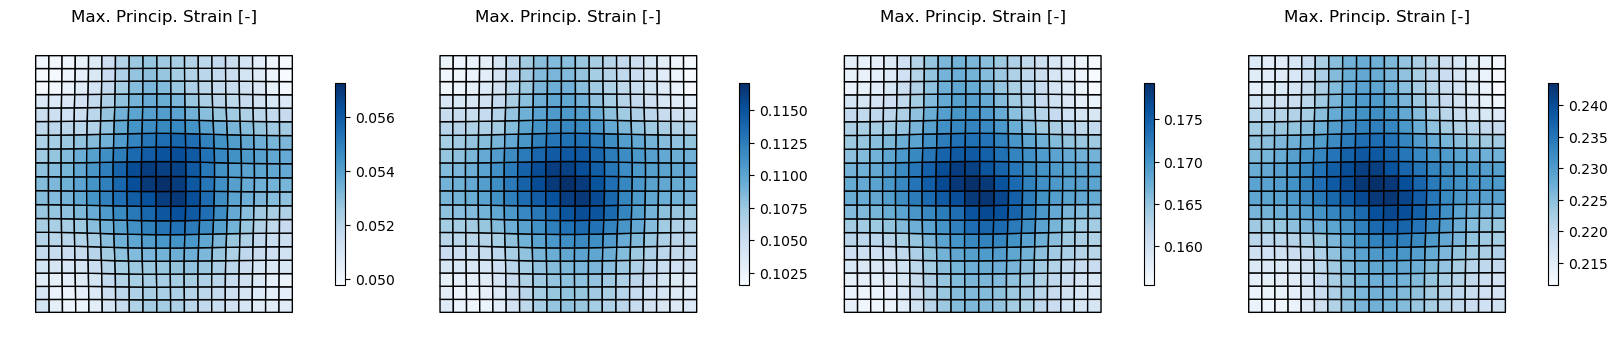

In [8]:
fig, axes = plt.subplots(1,4,figsize=(20,4))
strains = []
t_hist = np.arange(len(lmb_hist))
for t, node_x, F, ax in zip(t_hist, node_x_hist, F_hist, axes):
    E = E_fun(F)
    evals, efuns = jnp.linalg.eigh(E)
    E_11, E_22 = evals.T

    mps = np.maximum(E_11, E_22)
    plotmesh(mesh.cells, mesh.points, mps, title='Max. Princip. Strain [-]', ax=ax); 